Fisher and Jaikumar algorithm for VRP and subtour elimination

In [8]:
import numpy as np
import pandas as pd
import pulp
import itertools
import haversine as hs
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm

In [9]:
# customer count ('0' is depot) 
customer_count = 12

# the number of vehicle
vehicle_count = 8

# the capacity of vehicle
vehicle_capacity = 50

# fix random seed
np.random.seed(seed=777)

# set depot latitude and longitude
depot_latitude = 40.748817
depot_longitude = 73.985428

# make dataframe which contains vending machine location and demand
df = pd.DataFrame({"latitude":np.random.normal(depot_latitude, 0.007, customer_count), 
                   "longitude":np.random.normal(depot_longitude, 0.007, customer_count), 
                   "demand":np.random.randint(10, 20, customer_count)})

# set the depot as the center and make demand 0 ('0' = depot)
df.iloc[0,0] = depot_latitude
df.iloc[0,1] = depot_longitude
df.iloc[0,2]= 0

In [10]:
df.head()

,latitude,longitude,demand
0,40.748817,73.985428,0
1,40.743057,73.975606,15
2,40.748359,73.981001,15
3,40.743823,73.981516,18
4,40.755161,73.976795,11


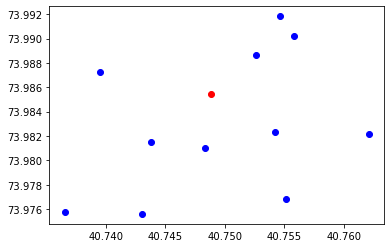

In [11]:
plt.scatter(df.iloc[1:,0], df.iloc[1:,1], c='blue')
plt.scatter(df.iloc[0,0], df.iloc[0,1], c='red')

In [12]:
distance_matrix = np.zeros((len(df),len(df)))

for i in range(df.shape[0]):
    for j in range(df.shape[0]):
        distance_matrix[i][j] = hs.haversine((df.iloc[i,0],df.iloc[i,1]), (df.iloc[j,0],df.iloc[j,1]))

In [14]:
for vehicle_count in range(1,vehicle_count+1):

    # definition of LpProblem instance
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # definition of variables which are 0/1
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]

    # add objective function
    problem += pulp.lpSum(distance_matrix[i][j] * x[i][j][k] if i != j else 0
                            for k in range(vehicle_count) 
                            for j in range(customer_count) 
                            for i in range (customer_count))

    # constraints
    # formula (2)
    for j in range(1, customer_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                for i in range(customer_count) 
                                for k in range(vehicle_count)) == 1 

    # formula (3)
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

    # formula (4)
    for k in range(vehicle_count):
        for j in range(customer_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                    for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

    #formula (5)
    for k in range(vehicle_count):
        problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range(1,customer_count)) <= vehicle_capacity 

    # print vehicle_count which needed for solving problem
    # print calculated minimum distance value

    if problem.solve() == 1:
        # count=0
        vehicle_req = vehicle_count
        while(1 == 1):
            var_sol = []
            for i in problem.variables():
                if i.varValue==1: 
                    var_sol.append(str(i))
                    
            subtour_veh = []
            dict = {}
            for i in range(vehicle_req):
                lst = []
                for j in range(len(var_sol)):
                    if int(var_sol[j].split(",")[-1]) == i:
                        lst.append(tuple([int(x) for x in var_sol[j].split(",")[0][1:].split('_')]))
                dict[i] = lst

            for key in dict:
                tpl = dict[key]
                start_dict = {item[0]: item for item in tpl}

                start = tpl[0][0]
                res = []
                try:
                    while start_dict:
                        item = start_dict[start]
                        del start_dict[start]
                        res.append(item)
                        start = item[-1]
                    dict[key] = res
                except:
                    subtour_veh.append(key)
            
            if len(subtour_veh)==0:
                break
            
            for k in subtour_veh:
                flat_var_sol_w_sub = [x for x in var_sol if int(x.split(",")[-1])== k]
                
                # print(flat_var_sol_w_sub)          
                subtours = []
                for i in range(len(flat_var_sol_w_sub)):
                    subtours.append(tuple([int(x) for x in flat_var_sol_w_sub[i].split(",")[0][1:].split("_")]))
                    
                # print(subtours)
                #formula (6) 
                for s in subtours:
                    problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2)) <= len(s) - 1
        
            problem.solve()
            # count = count + 1
            # print(count)

        print('Vehicle Requirements:', vehicle_req)
        print('Moving Distance:', pulp.value(problem.objective))
        break

Vehicle Requirements: 4
Moving Distance: 10.719789818047383


In [15]:
dict

{0: [(0, 7), (7, 8), (8, 1), (1, 0)],
 1: [(0, 3), (3, 2), (2, 0)],
 2: [(0, 6), (6, 9), (9, 10), (10, 0)],
 3: [(0, 4), (4, 11), (11, 5), (5, 0)]}

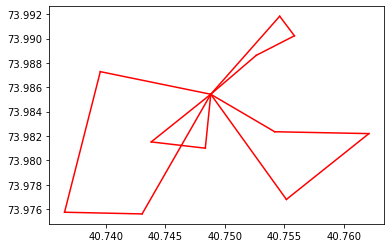

In [16]:
# color_list = ["red","blue","green", "orange"]

for key , values in dict.items():
    for i in range(len(values)):
        plt.plot([df.iloc[values[i][0],0], df.iloc[values[i][1],0]] , [df.iloc[values[i][0],1], df.iloc[values[i][1],1]] , c='red')
        

In [ ]:
import pyomo.environ as pe
import pyomo.opt as po
import os

current_directory = os.getcwd()

In [ ]:
for vehicle_count in range(1,vehicle_count+1):

    i = set(range(customer_count))
    j = set(range(customer_count))
    k = set(range(vehicle_count))

    model = pe.ConcreteModel()
    model.i = pe.Set(initialize = i)
    model.j = pe.Set(initialize = j)
    model.k = pe.Set(initialize = k)


    dist_dict = {(i,j,k): distance_matrix[i][j] for i in range(len(distance_matrix)) for j in range(len(distance_matrix[0])) for k in range(vehicle_count)}
    data_2 = {(i, j, k):d for (i, j, k), d in dist_dict.items() if i != j}

    demand_dict = df.demand.to_dict()

    model.ij_2 = pe.Set(initialize=data_2.keys())
    model.c = pe.Param(model.ij_2, initialize=data_2)
    model.q = pe.Param(model.i, initialize = demand_dict)
    model.veh_cap = pe.Param(initialize=vehicle_capacity)
    model.x = pe.Var(model.ij_2, domain=pe.Binary)

    # add objective function
    obj_exp = pe.quicksum(model.c[l,m,n]*model.x[l,m,n] for l in model.i for m in model.j for n in model.k if l!=m)
    model.objective = pe.Objective(expr=obj_exp, sense=pe.minimize)

    # constraints

    # formula (2)
    model.a = pe.ConstraintList()
    for m in range(1, customer_count):
        lhs = pe.quicksum(model.x[l,m,n] for l in model.i for n in model.k if l!=m)
        rhs = 1
        model.a.add(lhs == rhs)

    # formula (3)
    model.b = pe.ConstraintList()
    for n in range(vehicle_count):
        lhs = pe.quicksum(model.x[0,m,n] for m in model.j if m!=0)
        rhs = 1
        model.b.add(lhs == rhs)

    model.c = pe.ConstraintList()
    for n in range(vehicle_count):
        lhs = pe.quicksum(model.x[l,0,n] for l in model.i if l!=0)
        rhs = 1
        model.c.add(lhs == rhs)

    # formula (4)
    model.d = pe.ConstraintList()
    for n in range(vehicle_count):
            for m in range(customer_count):
                lhs = pe.quicksum(model.x[l,m,n] for l in model.i if l!=m) - pe.quicksum(model.x[m,l,n] for l in model.i if l!=m)
                rhs = 0
                model.d.add(lhs == rhs)

    #formula (5)
    model.e = pe.ConstraintList()
    for n in range(vehicle_count):
        lhs = pe.quicksum(model.q[m]*model.x[l,m,n] for l in model.i for m in range(1,customer_count) if l!=m)
        rhs = model.veh_cap
        model.e.add(lhs <= rhs)

    # formula (6)
    model.f = pe.ConstraintList()
    subtours = []
    for i in range(2,customer_count):
            subtours += itertools.combinations(range(1,customer_count), i)

    for s in subtours:
        lhs = pe.quicksum(model.x[l,m,n] for l, m in itertools.permutations(s,2) for n in range(vehicle_count) if l!=m)
        rhs = len(s) - 1
        model.f.add(lhs <= rhs)
  
    # model.pprint()
    try:
        solver = po.SolverFactory('cbc',executable=r'D:\data science\vehicle routing\cbc-win64\cbc.exe')
        # solver.options = {'sec': 30, 'threads': 6,'ratio': 0.01,  'slog': 3}
        result = solver.solve(model, tee=True)
        if result.Solver.Status[:] =='ok':
            break     
    except:
        pass

    (type: set).  This WILL potentially lead to nondeterministic behavior in
    Pyomo
    (type: set).  This WILL potentially lead to nondeterministic behavior in
    Pyomo
    (type: set).  This WILL potentially lead to nondeterministic behavior in
    Pyomo
    'pyomo.core.base.param.IndexedParam'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.constraint.ConstraintList'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Nov 24 2021 

command line - D:\data science\vehicle routing\cbc-win64\cbc.exe -printingOptions all -import C:\Users\soumya\AppData\Local\Temp\tmp7qgziiz_.pyomo.lp -stat=1 -solve -solu C:\Users\soumya\AppData\Local\Temp\tmp7qgziiz_.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve determined that the problem was infeasible with tolerance of 1e-08
Presol

In [ ]:
for k in range(vehicle_count):
    for j in range(customer_count):
            for i in range (customer_count):
                if i!=j:
                    if pe.value(model.x[i,j,k])==1:
                        print(i,j,k)

6 0 0
0 2 0
2 3 0
3 6 0
7 0 1
0 1 1
8 7 1
1 8 1
5 0 2
9 4 2
4 5 2
0 9 2
